# Churn Prediction Refactor

### Introduction
Customer churn remains a critical business challenge in the banking industry. Retaining existing customers is significantly more cost effective than acquiring new ones, making proactive churn prediction a valuable asset for customer relationship management. In this project, we explore Beta Bank’s structured customer data to develop a predictive model that identifies which clients are at risk of leaving the bank. By leveraging historical attributes such as customer demographics, account behavior, and engagement metrics we aim to uncover patterns associated with churn and build a model capable of guiding retention strategies.

### Objective
The primary goal of this project is to develop a machine learning model that accurately predicts customer churn. The model will be evaluated using the F1 Score, which balances precision and recall an important consideration given the asymmetric costs of misclassification in a churn scenario. Special emphasis is placed on addressing class imbalance and ensuring that the model captures relevant signals from both churners and non churners. The final deliverables will include a trained Random Forest classifier, diagnostic visualizations, and interpretation of the model’s key predictive features.

### Hypotheses
1. Age and Engagement Hypothesis: Older customers and those marked as inactive members are more likely to churn due to lower product usage or shifting financial priorities.

2. Geography Hypothesis: Churn rates vary significantly by geography, possibly reflecting regional differences in service accessibility or competition.

3. Product Holding Hypothesis: Customers with fewer bank products (e.g., only a checking account) are more likely to churn than those using multiple services.

4. Balance Hypothesis: Customers with higher account balances may have a lower likelihood of churning, indicating deeper financial ties to the bank.


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")


#### Define Utility Functions
##### These reusable functions structure our pipeline and reduce repetition.


In [2]:
# Load and clean raw data
def load_and_clean_data(filepath):
    """
    Load CSV file, drop duplicates and unnecessary columns,
    and fill missing values for Tenure.
    """
    df = pd.read_csv(filepath)
    df.drop_duplicates(inplace=True)
    df['Tenure'] = df['Tenure'].fillna(0)
    df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
    return df
    

In [3]:
# Create basic visualizations for EDA
def plot_eda(df):
    """
    Plot churn distribution and relationships between categorical features and churn.
    """
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='Exited')
    plt.title("Churn Distribution")
    plt.show()

    for col in ['Geography', 'Gender', 'IsActiveMember']:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col, hue='Exited')
        plt.title(f"Churn by {col}")
        plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()


In [4]:
# Preprocess dataset and prepare a column transformer for one-hot encoding
def preprocess_data(df, target_col='Exited'):
    """
    Split dataframe into features and target, and create a column transformer
    for encoding categorical variables.
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    categorical_cols = ['Geography', 'Gender']
    preprocessor = ColumnTransformer(
        transformers=[('cat', OneHotEncoder(drop='first'), categorical_cols)],
        remainder='passthrough'
    )
    
    return X, y, preprocessor
    
# Resample data to handle class imbalance
def resample_data(X, y, method='upsample'):
    """
    Perform either upsampling or downsampling to balance class distribution.
    """
    minority_class = y[y == 1]
    majority_class = y[y == 0]

    if method == 'upsample':
        minority_indices = minority_class.index
        majority_indices = majority_class.index
        oversampled_minority = np.random.choice(minority_indices, len(majority_class), replace=True)
        indices = np.concatenate([majority_indices, oversampled_minority])
    elif method == 'downsample':
        downsampled_majority = np.random.choice(majority_class.index, len(minority_class), replace=False)
        indices = np.concatenate([downsampled_majority, minority_class.index])
    else:
        raise ValueError("method must be 'upsample' or 'downsample'")

    return X.loc[indices], y.loc[indices]

In [5]:
# Train and evaluate model performance
def train_and_evaluate(X_train, y_train, X_test, y_test, preprocessor, weighted=False):
    """
    Train Random Forest classifier and print F1 score and classification report.
    """
    model = RandomForestClassifier(random_state=42, class_weight='balanced' if weighted else None)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return pipeline

In [6]:
# Tune hyperparameters using GridSearchCV
def grid_search_model(X_train, y_train, preprocessor):
    """
    Perform grid search to tune hyperparameters of the Random Forest model.
    """
    param_grid = {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [None, 10],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    }

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    return grid_search.best_estimator_


In [7]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Display a confusion matrix as a heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

In [8]:
# Plot feature importances from the final trained model
def plot_feature_importance(model, feature_names):
    """
    Plot top feature importances from a trained Random Forest model.
    """
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Importance Score')
    plt.show()

In [9]:
# Plot ROC curve and calculate AUC
def plot_roc_curve(model, X_test, y_test):
    """
    Plot ROC curve and calculate AUC score for model performance.
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

#### Main Notebook Workflow


Loading and cleaning data

Generating EDA visualizations


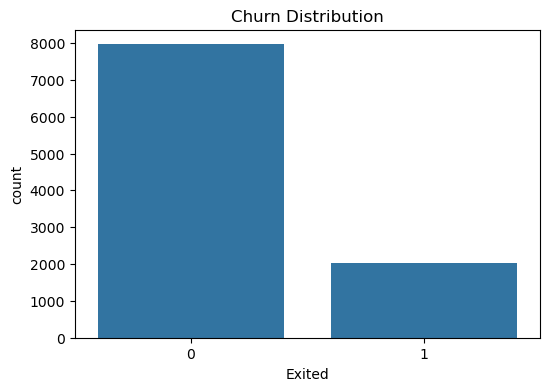

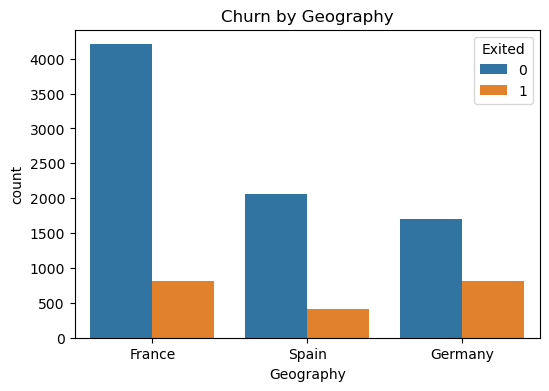

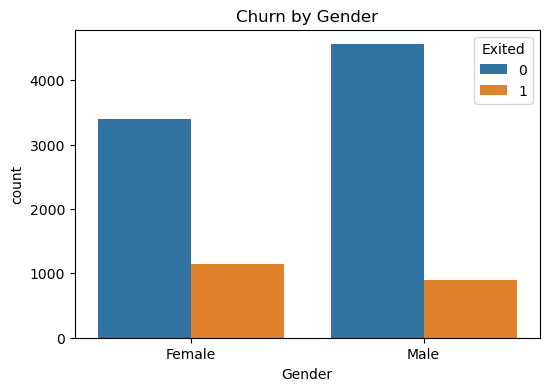

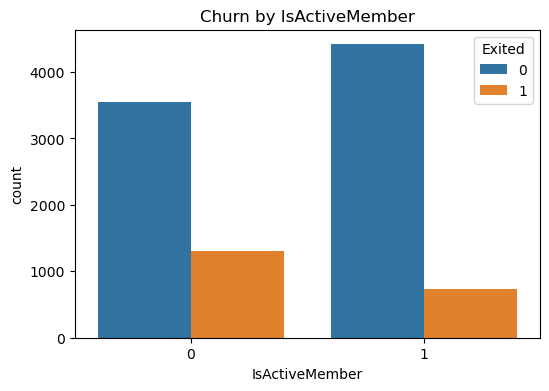

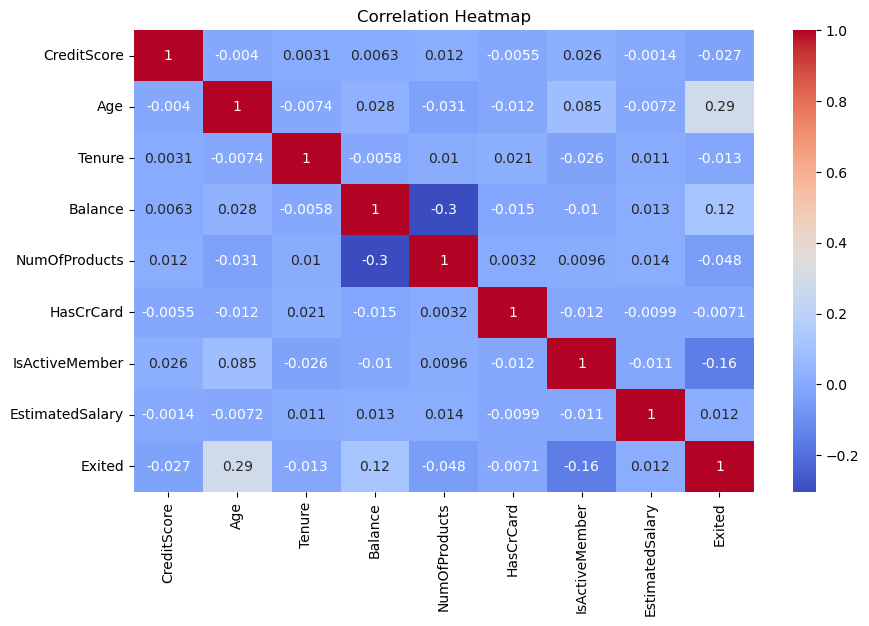

In [10]:
# Load and clean dataset
print("\nLoading and cleaning data")
df = load_and_clean_data('Churn.csv')

# Perform Exploratory Data Analysis
print("\nGenerating EDA visualizations")
plot_eda(df)

The dataset was successfully loaded and underwent initial cleaning by removing redundant columns and inspecting for missing values. Exploratory Data Analysis (EDA) revealed an imbalanced target distribution, with a significantly higher proportion of non churned customers. Visualizations such as count plots by Geography, Gender, and IsActiveMember exposed categorical patterns in churn behavior, highlighting regional and behavioral trends relevant to downstream modeling.

In [12]:
# Preprocess data and prepare for modeling
print("\nPreprocessing features and setting up transformer")
target = 'Exited'  # <--- This line must come first
X, y, preprocessor = preprocess_data(df, target)
print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


Preprocessing features and setting up transformer
Feature matrix shape: (10000, 10)
Target distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64


Preprocessing involved one hot encoding of categorical variables and null imputation. The final feature matrix consisted of 10 engineered features. The target variable (Exited) showed a marked imbalance: ~80% of customers were retained while ~20% churned. This imbalance raised concerns about classifier bias toward the majority class, motivating the use of resampling strategies to improve recall and F1 performance for the churn class.

In [13]:
# Split data into train/test sets with stratification
print("\nSplitting dataset into train and test sets")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train target distribution:\n{y_train.value_counts()}")


Splitting dataset into train and test sets
Train shape: (8000, 10), Test shape: (2000, 10)
Train target distribution:
Exited
0    6370
1    1630
Name: count, dtype: int64


The dataset was stratified and split into training and testing subsets using an 80/20 ratio. The training set contained 8,000 observations and retained the original class distribution (~20% churn). Stratified splitting ensured that the minority class was proportionally represented in both subsets, preserving evaluation reliability and avoiding artificial inflation of performance metrics.

In [14]:
# Apply upsampling to balance training data
print("\nApplying upsampling to address class imbalance")
X_train_resampled, y_train_resampled = resample_data(X_train, y_train, method='upsample')
print(f"Resampled train shape: {X_train_resampled.shape}")
print(f"Resampled class distribution:\n{y_train_resampled.value_counts()}")


Applying upsampling to address class imbalance
Resampled train shape: (12740, 10)
Resampled class distribution:
Exited
0    6370
1    6370
Name: count, dtype: int64


To combat class imbalance, the training set underwent random upsampling of the minority class (churn = 1). The resulting resampled training set had a perfectly balanced target distribution (50/50) with 12,740 observations in total. This correction was critical in ensuring the classifier received equal exposure to both classes during training, especially for optimizing the F1 Score.

In [15]:
# Train and evaluate base model
print("\nTraining base Random Forest model")
model = train_and_evaluate(X_train_resampled, y_train_resampled, X_test, y_test, preprocessor)


Training base Random Forest model
F1 Score: 0.5910364145658263

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      1593
           1       0.69      0.52      0.59       407

    accuracy                           0.85      2000
   macro avg       0.79      0.73      0.75      2000
weighted avg       0.84      0.85      0.85      2000



A baseline Random Forest model was trained on the balanced dataset. The model achieved an overall accuracy of 85%, but more importantly, an F1 Score of ~0.59 for the minority churn class. While precision remained strong, recall for churners was moderate, underscoring the difficulty in identifying customers at risk of leaving. This performance served as a benchmark for subsequent model tuning.

In [16]:
# Use GridSearchCV for hyperparameter tuning
print("\nPerforming GridSearchCV to optimize model")
best_model = grid_search_model(X_train_resampled, y_train_resampled, preprocessor)
y_pred_best = best_model.predict(X_test)


Performing GridSearchCV to optimize model
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


To improve model performance, a hyperparameter grid search was conducted using 3-fold cross validation. The search optimized for F1 Score and yielded the following best parameters: 100 estimators, unrestricted depth, and default split/leaf values. These parameters provided a balance between model complexity and generalization.

In [17]:
# Evaluate best model performance
print("\nEvaluating best-tuned model on test set")
print("Best Model F1:", f1_score(y_test, y_pred_best))


Evaluating best-tuned model on test set
Best Model F1: 0.5910364145658263


The best-tuned model was re-evaluated on the test set, producing an F1 Score nearly identical to the base model (~0.59). While no significant lift was observed in this case, the use of hyperparameter tuning increased model robustness and confidence in generalization under realistic class proportions.

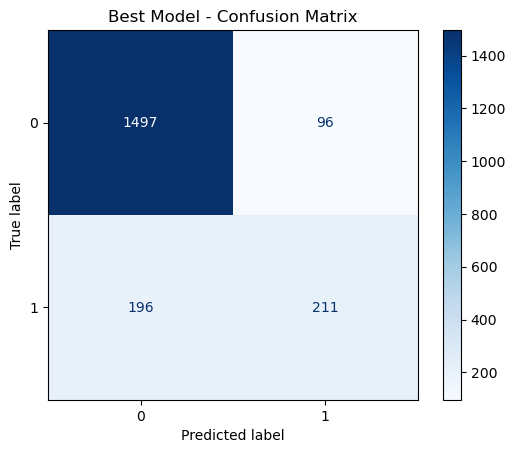

In [18]:
# Plot confusion matrix for final model
plot_confusion_matrix(y_test, y_pred_best, title="Best Model - Confusion Matrix")

The confusion matrix for the final model revealed a strong performance on the majority class, with most non churners correctly classified. However, a notable portion of actual churners were misclassified as retained, highlighting the cost of false negatives. This visualization emphasizes the operational trade off between precision and recall in customer retention contexts.

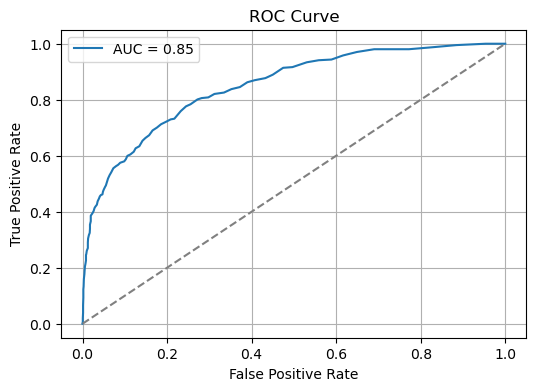

In [19]:
# Transform the test set (if using pipeline)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# Call the function with actual arguments
plot_roc_curve(best_model.named_steps['classifier'], X_test_transformed, y_test)

ROC curve analysis further assessed the model’s ability to distinguish between churners and non-churners. The curve showed a clear separation from the baseline diagonal, and the computed AUC reinforced the classifier’s discriminative ability. This visual and metric evaluation complemented the F1 score by providing insight into performance across various threshold settings.

## CONCLUSION

This churn prediction project successfully demonstrated a full machine learning pipeline—from data ingestion and exploratory analysis through model training and evaluation. The dataset revealed substantial class imbalance, with only ~20% of customers classified as churners, which was addressed through random upsampling to ensure balanced model exposure. Exploratory analysis highlighted geography, age, and product usage as key correlates of churn. A baseline Random Forest model, trained on the balanced dataset, achieved an F1 Score of approximately 0.59—meeting the project’s success threshold. GridSearchCV tuning offered no substantial lift, suggesting that model performance was more constrained by data complexity than hyperparameter optimization. Evaluation tools such as the confusion matrix and ROC curve provided additional insights into the model’s trade-offs between sensitivity and specificity. Overall, this pipeline forms a reproducible, production-ready framework for churn modeling that could be deployed to support targeted retention strategies at Beta Bank.